# Data Leakage and Binary Classification
1. [Data Leakage](#1)
2. [Binary Classification Task](#2)

## Data Leakage
<a id="1"></a>
1. What is data leakage?
    - Data leakage is a significant problem in machine learning when developing predictive models. It occurs when your training data contains information about the target variable. This leads to high accuracy values in the training set (and possibly in the validation data as well), but the model will perform poorly during the deployment phase.

        In simpler terms, data leakage happens when the model unintentionally learns from information that it shouldn't have access to, making it seem more accurate during development but less effective in real-world scenarios.

2. Two types of data leakage: Target Leakage, Leakage During Preprocessing
    - 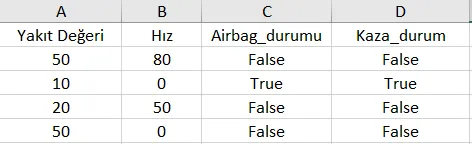
    - Data leakage during data preprocessing is a critical concern in machine learning. It happens when information from the target variable or unavailable data accidentally influences the training process, leading to overly optimistic model performance. This can cause the model to underperform in real-world scenarios, invalidate feature importance measures, and result in model overfitting. To avoid data leakage, it's essential to maintain a clear separation between training and testing data using techniques like holdout sets or cross-validation. Preventing data leakage ensures more reliable and ethical machine learning models.

3. How to detect and prevent data leakage?
   - To prevent overfitting and data leakage in machine learning models, consider the following steps:

   - Be cautious of abnormally high correlations between features and address them carefully.
   - Avoid scaling training and test data separately; use fit_transform() on training data and transform() on test data.
   - Never use fit_transform() on test or production data; use transform() with the learned parameters from training data.
   - Investigate features with very high model weights as they may indicate data leakage or overfitting.
   - Use a validation set to mimic real-world scenarios and evaluate the model before deployment.
   - Implement cross-validation, especially with limited data during the training process.
   - Utilize data preprocessing in a pipeline and conduct performance evaluation with cross-validation.
   - By following these guidelines, you can build more reliable and generalized machine learning models.

## Binary Classification
<a id="2"></a>
1. [Case nedir?](#3)
2. [Preprocessing Özeti](#4)
3. [Model Sonuçları Karşılaştırma](#5)
4. [Model Explainabilitiy](#6)

### What is case?
<a id="3"></a>
- Predict the presence of kidney stones based on urine analysis. What does this really mean? We ultimately want to predict some target (X) by using various inputs(y)s. In this case we want to predict the presence of Kidney Stones, `1 = we see a presence` and `0 = We see no presence`, Therefore this is a `Binary Classification` problem where something exists or it doesn't.
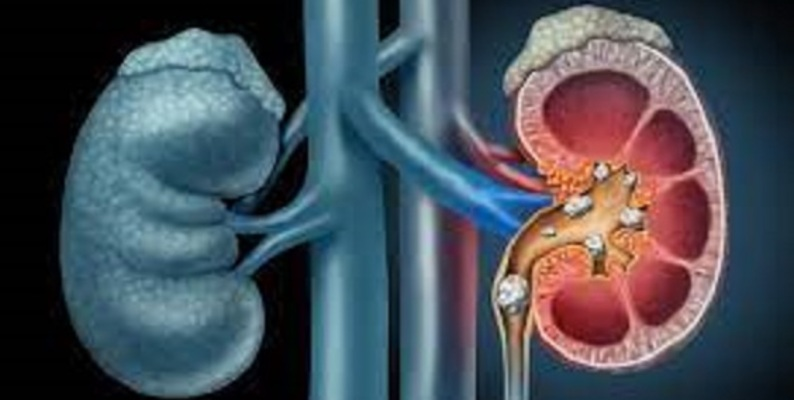

In [118]:
#İmporting Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold,StratifiedKFold,RepeatedKFold,train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve,RocCurveDisplay
warnings.filterwarnings("ignore")

#### Basic dataset informations

In [119]:
df=pd.read_csv("kindey stone urine analysis.csv")
df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,0
3,1.011,5.51,408,12.6,224,2.15,0
4,1.005,6.52,187,7.5,91,1.16,0


General informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  79 non-null     float64
 1   ph       79 non-null     float64
 2   osmo     79 non-null     int64  
 3   cond     79 non-null     float64
 4   urea     79 non-null     int64  
 5   calc     79 non-null     float64
 6   target   79 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 4.4 KB
None 


Dataset shape

(79, 7) 


Has any mising value in dataset?

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64


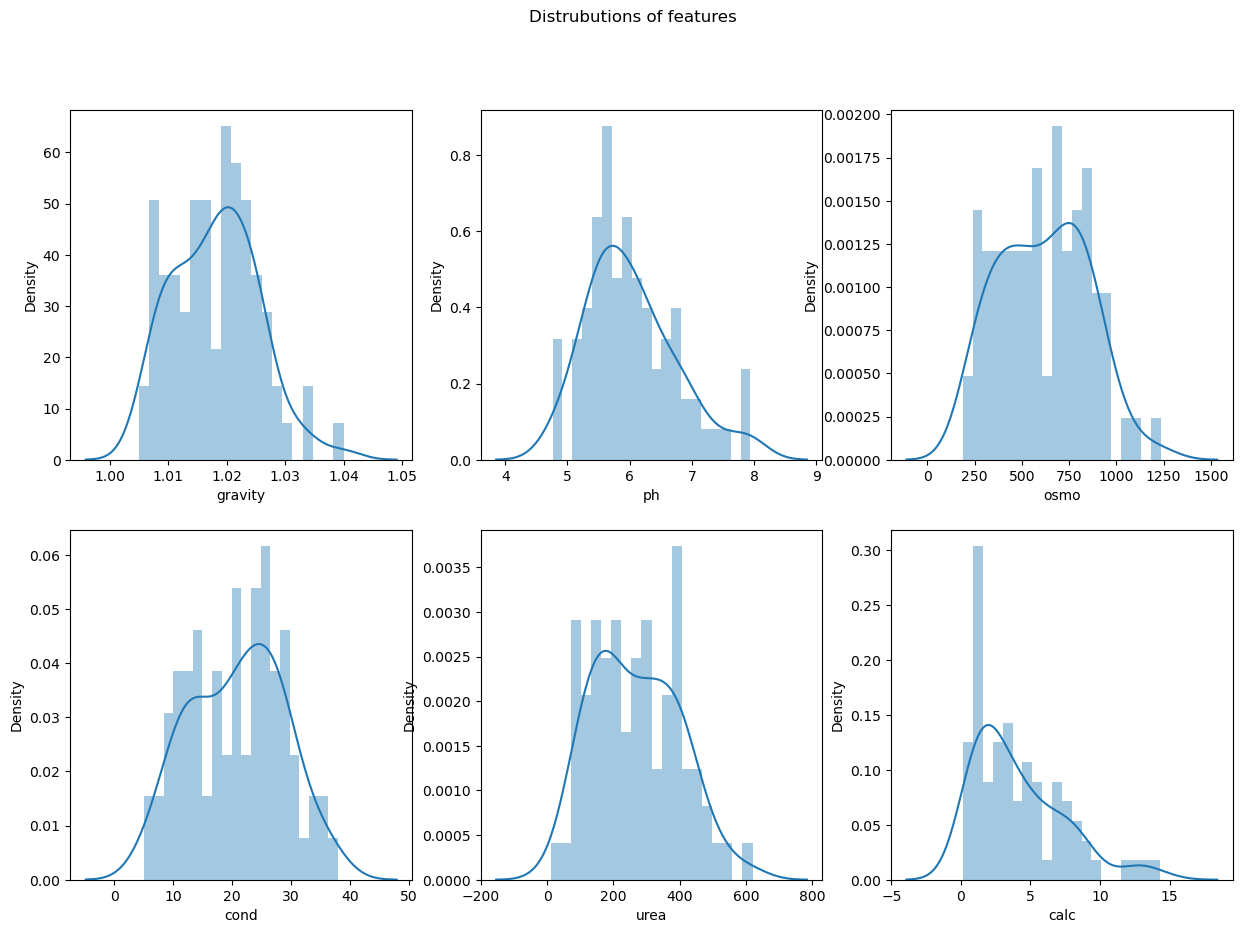

In [120]:
print("General informations\n")
print(df.info(),"\n\n")
print("="*20)
print("Dataset shape\n")
print(df.shape,"\n\n")
print("="*20)
print("Has any mising value in dataset?\n")
print(df.isnull().sum())

fig,axes=plt.subplots(2,3,figsize=(15,10))
fig.suptitle("Distrubutions of features")
for i,column in enumerate(list(df.drop(columns="target").columns)):
    row=i//3
    col=i%3
    sns.distplot(df[column],ax=axes[row,col],bins=20)
    

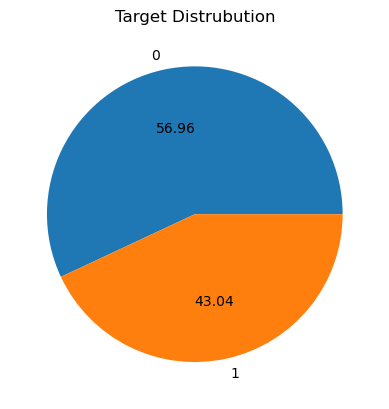

In [121]:
plt.pie(x=list(df["target"].value_counts()),labels=[0,1],autopct="%.2f")
plt.title("Target Distrubution")
plt.show()

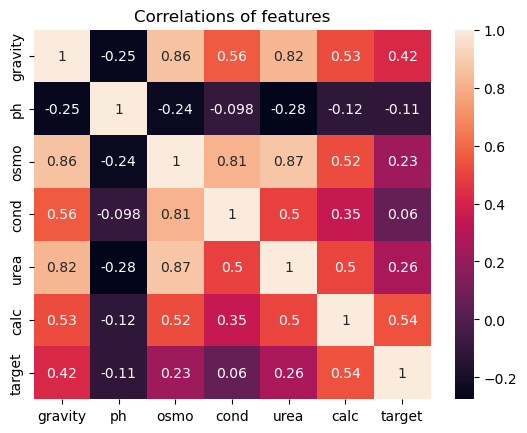

In [122]:
sns.heatmap(df.corr(),annot=True)
plt.title("Correlations of features")
plt.show()

### Data Preprocessing
<a id="4"></a>
- I created two classes in the data preprocessing step, named "Splitting" and "Scaler," with the purpose of quickly trying out different data splitting methods and scaling techniques. The main goal was to streamline the process.


- Afterwards, with the help of ChatGPT, I generated numerous features. You will be able to see the contribution of these features to the model at the end of the presentation. In general, the generated features are the mathematical transformations of the features present in the dataset.


- Due to limited data, I chose the "repeated_kfold" method for data splitting and the "minmax" method for scaling. These methods yielded the best results in the models.

In [123]:
#Data Splitting
class Splitting:
    
    def __init__(self,data,labels,method="train_test_split",train_size=0.7,test_size=0.3,random_state=42,n_splits=3):
        
    
        if not (train_size +  test_size == 1.0):
                raise ValueError("The sum of train_size, and test_size must be equal to 1.0.")

        self.data = data
        self.labels = labels
        self.method = method
        self.train_size = train_size
        self.test_size = test_size
        self.random_state = random_state
        self.n_splits=n_splits
    
    
    def _train_test_split(self):
        """
        Perform a simple train-test split.

        Returns:
            tuple: A tuple containing the following numpy arrays in order:
                - X_train: Training data
                
                - X_test: Testing data
                - y_train: Training labels
                
                - y_test: Testing labels
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.data, self.labels, train_size=self.train_size, random_state=self.random_state
        )

        """remaining_size = self.val_size + self.test_size
        relative_val_size = self.val_size / remaining_size

        X_val, X_test, y_val, y_test = train_test_split(
            X_temp,
            y_temp,
            test_size=remaining_size,
            random_state=self.random_state,
            stratify=y_temp if isinstance(self.labels[0], (int, np.int32, np.int64)) else None,
        )"""

        return X_train, X_test, y_train, y_test

    def _kfold(self):
        """
        Perform K-Fold cross-validation.

        Returns:
            list: A list of K-Fold splits, each containing tuples of training and validation indices.
        """
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        return list(kf.split(self.data))

    def _stratified_kfold(self):
        """
        Perform Stratified K-Fold cross-validation.

        Returns:
            list: A list of Stratified K-Fold splits, each containing tuples of training and validation indices.
        """
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        return list(skf.split(self.data, self.labels))

    def _repeated_kfold(self, n_repeats=3):
        """
        Perform Repeated K-Fold cross-validation.

        Returns:
            list: A list of Repeated K-Fold splits, each containing tuples of training and validation indices.
        """
        rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=n_repeats, random_state=self.random_state)
        return list(rkf.split(self.data))

    def split_data(self):
        """
        Split the data based on the specified method.

        Returns:
            list or tuple: Depending on the method specified, it returns either a list of splits (for KFold, StratifiedKFold, or RepeatedKFold)
            or a tuple containing the following numpy arrays in order: (X_train, X_val, X_test, y_train, y_val, y_test).
        """
        if self.method == 'train_test_split':
            return self._train_test_split()
        elif self.method == 'kfold':
            
            return self._kfold()
        elif self.method == 'stratified_kfold':
            return self._stratified_kfold()
        elif self.method == 'repeated_kfold':
            return self._repeated_kfold()
        else:
            raise ValueError("Invalid splitting method. Supported methods are 'train_test_split', 'kfold', 'stratified_kfold', or 'repeated_kfold'.")
        

In [124]:
#SCALİNG
class Scaler:
    
    def __init__(self,train,test,method="minmax"):
        self.train=train
        self.test=test
        self.method=method
        
    
    def _minmax(self,feature_range=(0,1)):
        minmax=MinMaxScaler(feature_range=feature_range)
        X_train_scaled=minmax.fit_transform(self.train)
        X_test_scaled=minmax.transform(self.test)
        
        return X_train_scaled,X_test_scaled
    
    def _standard(self):
        standard_scaler=StandardScaler()
        X_train_scaled=standard_scaler.fit_transform(self.train)
        X_test_scaled=standard_scaler.transform(self.test)
        
        return X_train_scaled,X_test_scaled
    
    def _robust(self):
        robust=RobustScaler()
        X_train_scaled=robust.fit_transform(self.train)
        X_test_scaled=robust.transform(self.test)
        
        return X_train_scaled,X_test_scaled
    
    def scale_data(self):
        
        if self.method=="minmax":
            
                
            return self._minmax()
            
        elif self.method=="standard":
            
            return self._standard()
        elif self.method=="robust":
            return self._robust()
        
        else:
            raise ValueError("Invalid scale method")

In [125]:
X=df.drop(columns="target")
y=df["target"]
splitter=Splitting(data=X,labels=y,method="train_test_split")
X_train,X_test,y_train,y_test=splitter.split_data()
print(X_train.shape)
print(X_test.shape)

(55, 6)
(24, 6)


In [176]:
# Feature Generation
def generate_feats(df):
    
    df['oxalate_concentration'] = df['calc'] / df['osmo']

    # Ratio of calcium to oxalate
    df['calc_to_oxalate_ratio'] = df['calc'] / df['oxalate_concentration']

    # Ion balance
    df['ion_balance'] = df['calc'] - df['oxalate_concentration']

    # Specific gravity to osmolarity ratio
    df['sg_to_osmo_ratio'] = df['gravity'] / df['osmo']

    # Urea to creatinine ratio
    df['urea_to_creatinine_ratio'] = df['urea'] / df['cond']

    # pH balance
    df['pH_balance'] = df['ph'].apply(lambda x: 1 if 5.5 <= x <= 7.5 else 0)

    # Osmolarity to conductivity ratio
    df['osmo_to_cond_ratio'] = df['osmo'] / df['cond']
    
    return df

X_train=generate_feats(X_train)
X_test=generate_feats(X_test)



In [177]:
X_train.head()

,gravity,ph,osmo,cond,urea,calc,oxalate_concentration,calc_to_oxalate_ratio,ion_balance,sg_to_osmo_ratio,urea_to_creatinine_ratio,pH_balance,osmo_to_cond_ratio
1,1.034,5.24,1236,27.3,620,12.68,0.010259,1236.0,12.669741,0.000837,22.710623,0,45.274725
3,1.022,6.21,442,20.6,398,4.18,0.009457,442.0,4.170543,0.002312,19.320388,1,21.456311
4,1.007,6.63,253,8.4,133,1.05,0.004150,253.0,1.045850,0.003980,15.833333,1,30.119048
6,1.031,5.73,874,17.4,516,3.01,0.003444,874.0,3.006556,0.001180,29.655172,1,50.229885
7,1.015,6.03,416,12.8,178,9.39,0.022572,416.0,9.367428,0.002440,13.906250,1,32.500000


### Training and Comparison
<a id="5"></a>
- I created a class named "Modelling" for the model training part. This class has been very helpful in allowing me to experiment with various aspects of model training in a practical manner. It contains multiple models.

In [128]:
class Modelling:
    
    def __init__(self):
        
        self.models={
            "LogisticRegression":LogisticRegression(),
            "RandomForest":RandomForestClassifier(),
            "GradientBoosting":GradientBoostingClassifier(),
            "Xgboost":XGBClassifier(),
            "LightGBM":LGBMClassifier(),
            "Catboost":CatBoostClassifier(verbose=0)
        }
        
        self.trained_models={}
        
    
    def train_model(self,model_name,X_train,y_train):
        if model_name not in self.models:
            raise ValueError("Invalid model name")
        model=self.models[model_name]
        model.fit(X_train,y_train)
        self.trained_models[model_name]=model
        
    def train_all_models(self,X_train,y_train):
        for model_name in self.models:
            self.train_model(model_name,X_train,y_train)
        
    def get_trained_model(self,model_name):
        
        if model_name not in self.trained_models:
            raise ValueError("Model has not been trained yet")
        
        return self.trained_models[model_name]
    
    def evaluate_model(self,model_name,X_test,y_test,metric="accuracy"):
        model=self.get_trained_model(model_name)
        y_pred=model.predict(X_test)
        if metric=="accuracy":
            
            accuracy=accuracy_score(y_pred,y_test)
            
            return accuracy
        elif metric=="recall":
            recall=recall_score(y_pred,y_test)
            return recall
        
        elif metric=="precision":
            precision=precision_score(y_pred,y_test)
            return precision
        else:
            raise ValueError("Invalid metric")

In [129]:
def run(scaler,X_train,y_train,X_test,y_test):
    if scaler!=None:
        
        scalerr=Scaler(method=scaler,train=X_train,test=X_test)
        X_train_scaled,X_test_scaled=scalerr.scale_data()
        trainer=Modelling()
        trainer.train_all_models(X_train_scaled,y_train)
        model_names=list(trainer.models.keys())
        metrics="recall"
        model_performances=[]
        for model in model_names:
            
            """for metric in metrics:
                print(f"Metric Name:{metric}")
                print(f"{model} results:",trainer.evaluate_model(model,X_test_scaled,y_test,metric=metric))
                print("\n\n")"""
            model_performances.append([model,trainer.evaluate_model(model,X_test_scaled,y_test,metric=metrics)])
        model_perf_dict={}

        
        model_perf_dict["model"]=[model_performances[i][0] for i in range(len(model_performances))]
        model_perf_dict["result"]=[model_performances[i][1] for i in range(len(model_performances))]
        results=pd.DataFrame(model_perf_dict)
        log_model=trainer.get_trained_model("LogisticRegression")
        return results,log_model
        
    else:
        trainer=Modelling()
        trainer.train_all_models(X_train,y_train)
        model_names=list(trainer.models.keys())
        metrics="recall"
        model_performances=[]
        for model in model_names:
            """for metric in metrics:
                print(f"Metric Name:{metric}")
                print(f"{model} results:",trainer.evaluate_model(model,X_test,y_test,metric=metric))
                print("\n\n")"""
            model_performances.append([model,trainer.evaluate_model(model,X_test,y_test,metric=metrics)])
        model_perf_dict={}

        
        model_perf_dict["model"]=[model_performances[i][0] for i in range(len(model_performances))]
        model_perf_dict["result"]=[model_performances[i][1] for i in range(len(model_performances))]
        results=pd.DataFrame(model_perf_dict)
        return results

In [130]:
X=pd.concat([X_train,X_test],axis=0).reset_index()
y=pd.concat([y_train,y_test],axis=0).reset_index()
X.drop(columns=["index"],inplace=True)
y.drop(columns="index",inplace=True)

In [131]:
y=y["target"]
y

0     0
1     1
2     0
3     1
4     0
     ..
74    0
75    0
76    1
77    0
78    1
Name: target, Length: 79, dtype: int64

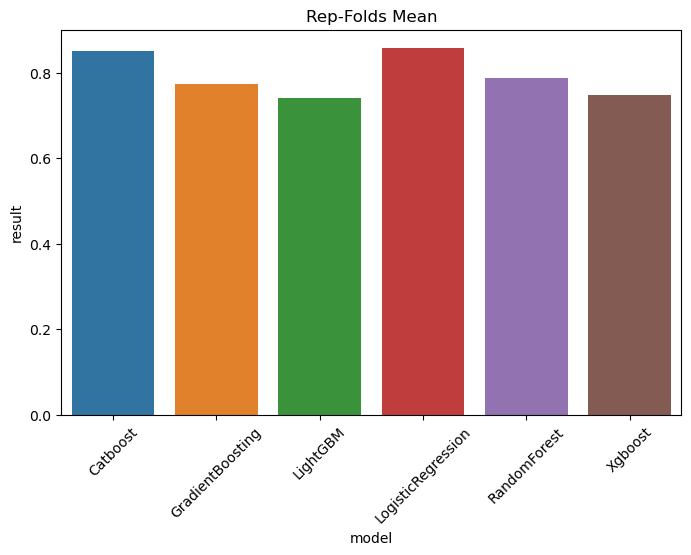

In [132]:
split=Splitting(X,y,method="repeated_kfold")
splits=split.split_data()
new_df=pd.DataFrame()
models=[]
for i,(train_index,test_index) in enumerate(splits):
    X_train,X_test=X.iloc[train_index,:],X.iloc[test_index,:]
    y_train,y_test=y[train_index],y[test_index]
    model_df,model=run(scaler="minmax",X_test=X_test,X_train=X_train,y_train=y_train,y_test=y_test)
    models.append(model)
    new_df=new_df.append(model_df,ignore_index=True)
vis_df=new_df.groupby(by="model")[["result"]].mean().reset_index()
plt.figure(figsize=(8,5))
plt.title("Rep-Folds Mean")
sns.barplot(x=vis_df["model"],y=vis_df["result"])
plt.xticks(rotation=45)
plt.show()

In [133]:
new_df.groupby(by="model")[["result"]].mean().reset_index()

,model,result
0,Catboost,0.850000
1,GradientBoosting,0.773124
2,LightGBM,0.741555
3,LogisticRegression,0.857407
4,RandomForest,0.788070
5,Xgboost,0.748696


#### Why I choose the recall score for this task?
- TP (True positive): It means patient to patient.

- FP (False positive): It means sick to someone who is not sick.

- TN (True negative): It means not sick to the person who is not sick.

- FN (False negative): It means that the sick person is not sick.

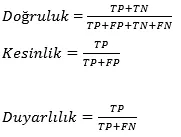

- Accuracy: Accuracy is the percentage of correctly classified examples. It measures how many of the total predictions are correct.


- Recall: Recall is a metric that shows how many of the positive instances that should have been predicted as positive were actually predicted as positive. It answers the question, "What proportion of actual positives were correctly identified?"


- Precision: Precision indicates the number of true positive predictions (correctly predicted positive instances) out of all positive predictions. It shows the proportion of predicted positives that were truly positive.

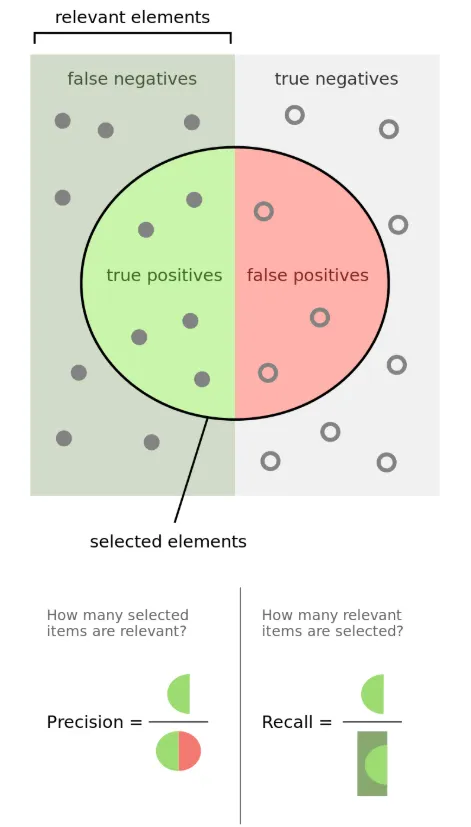

###### Let's get to the main point, why did I choose Recall?
- Since our primary goal is to detect sick individuals, the True Positive (TP) rate is crucial for us. We are interested in knowing how many of the actual positive cases were correctly identified as positive. Therefore, in this problem, the most suitable metric is Recall.

### Model Explainability
<a id="6"></a>

In [134]:
models=models[0]

###### Coefficient Interpretation
- The coefficients in logistic regression represent the weightage given to each feature. Positive coefficients indicate that an increase in the corresponding feature will increase the likelihood of the positive class, while negative coefficients suggest the opposite. The magnitude of the coefficients indicates the strength of the impact.

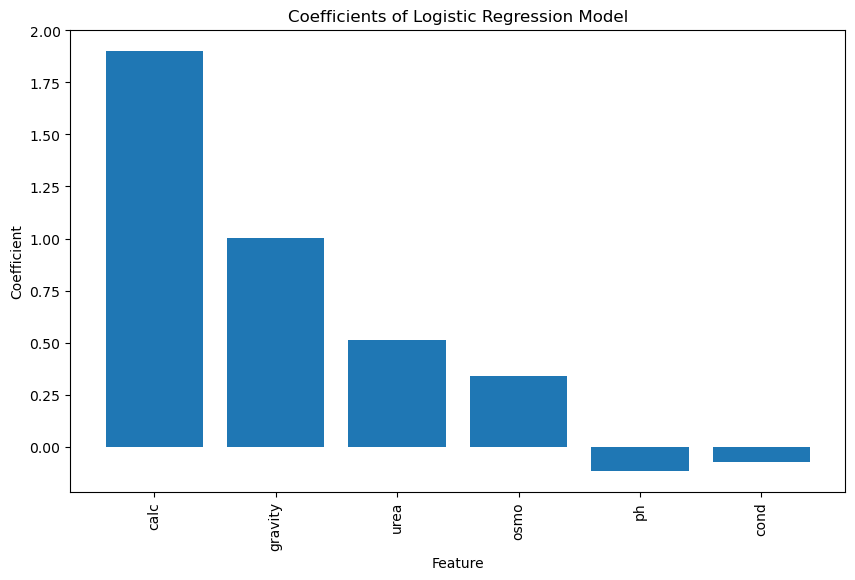

In [135]:
coefficients=models.coef_[0]
feat_names=X_train.columns
coeff_df=pd.DataFrame({"Feature":feat_names,"Coefficient":coefficients})
coeff_df["abs_coeff"]=np.abs(coeff_df["Coefficient"])
coeff_df=coeff_df.sort_values(by="abs_coeff",ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

###### Individual Predictions
- To explain individual predictions, you can use various techniques like SHAP (SHapley Additive exPlanations) values.These technique provide insight into how each feature contributes to a specific prediction. In this example, we'll use SHAP values.

In [136]:
explainer=shap.LinearExplainer(model,X_test)
shap_values=explainer.shap_values(X_train)

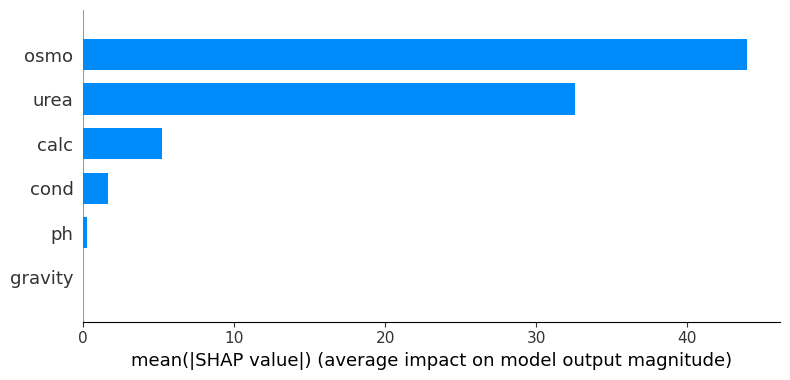

In [137]:
shap.summary_plot(shap_values,X_train,feature_names=list(X_train.columns),plot_type="bar")

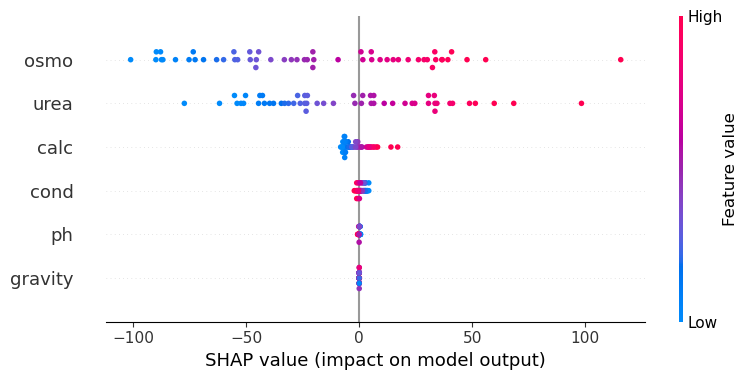

In [138]:
shap.summary_plot(shap_values,X_train,feature_names=feat_names)

In [139]:
X_train.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

In [140]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 1 to 78
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  53 non-null     float64
 1   ph       53 non-null     float64
 2   osmo     53 non-null     int64  
 3   cond     53 non-null     float64
 4   urea     53 non-null     int64  
 5   calc     53 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.9 KB


In [141]:
models

LogisticRegression()

In [142]:
import pickle
#pickle.dump(models,open("C:/Users/ismai/OneDrive/Masaüstü/Galaksiya Staj/Deploy/model.pkl","wb"))

In [143]:
scaler=MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.51428571,  0.34493671,  0.74642517,  1.14634146,  0.57704918,
         0.30348259],
       [ 0.28571429,  0.64240506,  0.33746425,  0.55052265,  0.29016393,
         0.1684435 ],
       [ 0.37142857,  0.44936709,  0.48331745,  0.63414634,  0.49344262,
         0.38166311],
       [ 0.68571429,  0.28797468,  0.87702574,  1.07317073,  0.8852459 ,
         0.58351102],
       [ 0.42857143,  0.29113924,  0.65681602,  1.06968641,  0.48852459,
         0.29992893],
       [ 0.08571429,  0.51898734,  0.14680648,  0.33101045,  0.18852459,
         0.0533049 ],
       [ 0.54285714,  0.31962025,  0.4871306 ,  0.50174216,  0.56393443,
         0.9047619 ],
       [ 0.31428571,  0.64873418,  0.38798856,  0.56794425,  0.40163934,
         0.84790334],
       [ 0.14285714,  0.58544304,  0.03622498,  0.16376307,  0.10163934,
        -0.00710732],
       [ 0.34285714,  0.90189873,  0.32411821,  0.72125436,  0.10655738,
         0.13503909],
       [ 0.45714286,  0.24367089,  0.56053384,  0.

In [144]:
#with open("C:/Users/ismai/OneDrive/Masaüstü/Galaksiya Staj/Deploy/scaler.pkl","wb") as f:
 #   pickle.dump(scaler, f)

In [178]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
minmax_scaler=MinMaxScaler()
logistic_regression=LogisticRegression()

pipeline=Pipeline(steps=[
    ("preprocessor",minmax_scaler),
    ("logistic_regression",logistic_regression)
])
pipeline

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('logistic_regression', LogisticRegression())])

In [179]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('logistic_regression', LogisticRegression())])

In [180]:
X_train

,gravity,ph,osmo,cond,urea,calc,oxalate_concentration,calc_to_oxalate_ratio,ion_balance,sg_to_osmo_ratio,urea_to_creatinine_ratio,pH_balance,osmo_to_cond_ratio
1,1.034,5.24,1236,27.3,620,12.68,0.010259,1236.0,12.669741,0.000837,22.710623,0,45.274725
3,1.022,6.21,442,20.6,398,4.18,0.009457,442.0,4.170543,0.002312,19.320388,1,21.456311
4,1.007,6.63,253,8.4,133,1.05,0.004150,253.0,1.045850,0.003980,15.833333,1,30.119048
6,1.031,5.73,874,17.4,516,3.01,0.003444,874.0,3.006556,0.001180,29.655172,1,50.229885
7,1.015,6.03,416,12.8,178,9.39,0.022572,416.0,9.367428,0.002440,13.906250,1,32.500000
9,1.026,5.16,822,26.0,301,14.34,0.017445,822.0,14.322555,0.001248,11.576923,0,31.615385
10,1.011,7.01,443,21.4,124,1.27,0.002867,443.0,1.267133,0.002282,5.794393,1,20.700935
11,1.014,6.14,565,23.6,214,1.45,0.002566,565.0,1.447434,0.001795,9.067797,1,23.940678
12,1.014,5.90,456,17.8,164,6.99,0.015329,456.0,6.974671,0.002224,9.213483,1,25.617978
13,1.017,6.76,455,8.8,270,0.77,0.001692,455.0,0.768308,0.002235,30.681818,1,51.704545


In [183]:
pickle.dump(pipeline,open("C:/Users/ismai/OneDrive/Masaüstü/Galaksiya Staj/Deploy/new_pipeline.pkl","wb"))

In [184]:
y_pred=pipeline.predict(X_test)
print(accuracy_score(y_pred
                    ,y_test))

0.6923076923076923


In [182]:
X_test

,gravity,ph,osmo,cond,urea,calc,oxalate_concentration,calc_to_oxalate_ratio,ion_balance,sg_to_osmo_ratio,urea_to_creatinine_ratio,pH_balance,osmo_to_cond_ratio
0,1.023,5.85,970,38.0,362,4.54,0.004680,970.0,4.535320,0.001055,9.526316,1,25.526316
2,1.015,6.79,541,20.9,187,2.64,0.004880,541.0,2.635120,0.001876,8.947368,1,25.885167
5,1.018,6.18,694,23.3,311,5.64,0.008127,694.0,5.631873,0.001467,13.347639,1,29.785408
8,1.029,5.67,1107,35.9,550,8.48,0.007660,1107.0,8.472340,0.000930,15.320334,1,30.835655
14,1.020,5.68,876,35.8,308,4.49,0.005126,876.0,4.484874,0.001164,8.603352,1,24.469274
23,1.008,6.40,341,14.6,125,1.02,0.002991,341.0,1.017009,0.002956,8.561644,1,23.356164
26,1.024,5.77,698,19.5,354,13.00,0.018625,698.0,12.981375,0.001467,18.153846,1,35.794872
27,1.016,6.81,594,21.4,255,12.20,0.020539,594.0,12.179461,0.001710,11.915888,1,27.757009
29,1.010,6.61,225,9.8,72,0.17,0.000756,225.0,0.169244,0.004489,7.346939,1,22.959184
31,1.017,7.61,527,25.8,75,2.17,0.004118,527.0,2.165882,0.001930,2.906977,0,20.426357


In [153]:
X_test

,gravity,ph,osmo,cond,urea,calc
0,1.023,5.85,970,38.0,362,4.54
2,1.015,6.79,541,20.9,187,2.64
5,1.018,6.18,694,23.3,311,5.64
8,1.029,5.67,1107,35.9,550,8.48
14,1.020,5.68,876,35.8,308,4.49
23,1.008,6.40,341,14.6,125,1.02
26,1.024,5.77,698,19.5,354,13.00
27,1.016,6.81,594,21.4,255,12.20
29,1.010,6.61,225,9.8,72,0.17
31,1.017,7.61,527,25.8,75,2.17


In [171]:
pipeline.predict([[1.23,3.5,200,31.6,50,4.3]])

array([1], dtype=int64)

In [172]:
y_train.value_counts()

0    29
1    24
Name: target, dtype: int64

In [158]:
X_train

,gravity,ph,osmo,cond,urea,calc
1,1.034,5.24,1236,27.3,620,12.68
3,1.022,6.21,442,20.6,398,4.18
4,1.007,6.63,253,8.4,133,1.05
6,1.031,5.73,874,17.4,516,3.01
7,1.015,6.03,416,12.8,178,9.39
9,1.026,5.16,822,26.0,301,14.34
10,1.011,7.01,443,21.4,124,1.27
11,1.014,6.14,565,23.6,214,1.45
12,1.014,5.90,456,17.8,164,6.99
13,1.017,6.76,455,8.8,270,0.77


0.38461538461538464
